In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rice_ml.supervised_learning import KNNClassifier

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (6, 4)


In [4]:
#Load dataset
df = pd.read_csv("../data/lesions_processed.csv")
df.head()


,x_norm,y_norm,slice_norm,r_xy,quad_x,quad_y,experiment,tampered,type,uuid,slice,x,y
0,0.678571,0.945409,0.198413,499.489740,1,1,1,1,FB,1280,100,323,381
1,0.743697,0.714640,0.150794,456.355125,1,1,1,1,FB,1009,76,354,288
2,0.342437,0.473945,0.156746,251.097591,0,0,1,1,FB,7794,79,163,191
3,0.710084,0.602978,0.186508,416.284758,1,1,1,1,FB,7794,94,338,243
4,0.327731,0.334988,0.089286,206.303175,0,0,1,1,FB,2997,45,156,135


In [5]:
feature_cols = [
    "x_norm",
    "y_norm",
    "slice_norm",
    "r_xy",
    "quad_x",
    "quad_y",
    "experiment",
]

target_col = "tampered"

X = df[feature_cols].values
y = df[target_col].values.astype(int)

X.shape, y.shape


((169, 7), (169,))

In [6]:
#Train data
rng = np.random.default_rng(42)

indices = np.arange(len(X))
rng.shuffle(indices)

test_size = int(0.2 * len(X))
test_idx = indices[:test_size]
train_idx = indices[test_size:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

X_train.shape, X_test.shape


((136, 7), (33, 7))

In [7]:
#Standardize
mean_ = X_train.mean(axis=0)
std_ = X_train.std(axis=0)
std_[std_ == 0] = 1.0

X_train_scaled = (X_train - mean_) / std_
X_test_scaled = (X_test - mean_) / std_


In [8]:
#Train KNN
results = []

for k in [3, 5, 7]:
    knn = KNNClassifier(n_neighbors=k, metric="euclidean", weights="uniform")
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)

    acc = (y_pred == y_test).mean()
    results.append((k, acc))
    print(f"k = {k}: accuracy = {acc:.3f}")


k = 3: accuracy = 0.788
k = 5: accuracy = 0.727
k = 7: accuracy = 0.727


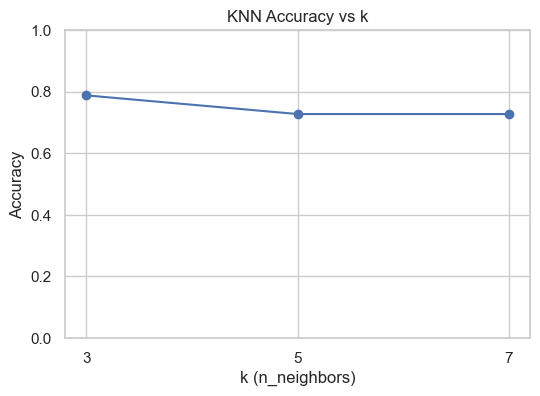

In [9]:
#Plot KNN
ks = [r[0] for r in results]
accs = [r[1] for r in results]

plt.plot(ks, accs, marker="o")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs k")
plt.xticks(ks)
plt.ylim(0, 1)
plt.show()


Finding the k that performed the best. Compare with logisitc regression. 

In [10]:
best_k = max(results, key=lambda t: t[1])[0]
best_k


3

In [11]:
knn_best = KNNClassifier(n_neighbors=best_k, metric="euclidean", weights="uniform")
knn_best.fit(X_train_scaled, y_train)
y_pred_best = knn_best.predict(X_test_scaled)

cm = np.zeros((2, 2), dtype=int)
for yt, yp in zip(y_test, y_pred_best):
    cm[yt, yp] += 1

cm


array([[ 7,  5],
       [ 2, 19]])

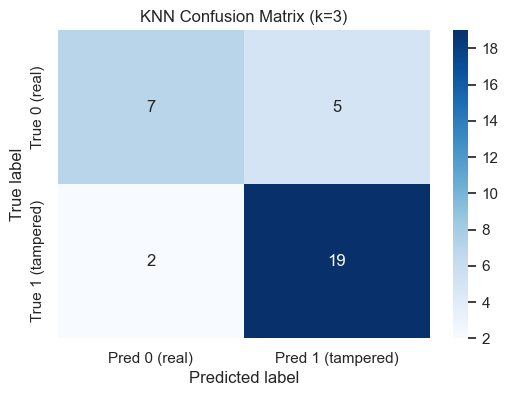

In [12]:
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0 (real)", "Pred 1 (tampered)"],
    yticklabels=["True 0 (real)", "True 1 (tampered)"],
)
plt.title(f"KNN Confusion Matrix (k={best_k})")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


Shows that:

True Negatives = 7
False Positives = 5
False Negatives = 2
True Positives = 19

k=3 performs strongly on this dataset.

The model correctly identifies 19 out of 21 tampered lesions. However, it misclassifiies 5 out of 12 real lesions as tampered. 

False negatives are low at 2 instances which could show the model is UNLIKELY to miss an injected fake cancer. Yay! But we want to still try to lower this. 

False positives are higher at 5 instances.